In [1]:
import os
import time
import torch
import random
import functions
import dataClass
import numpy as np
import numpy as np
import torchsummary
import pandas as pd
import torch.nn as nn
from pesq import pesq
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

### Data Import

In [2]:
filepath = "./data_details.csv"
df = functions.read_csv_data(filepath)
df = df.iloc[:2500]
print(df.shape)
df.head()

(2500, 17)


Unnamed: 0  mixed     near_end     far_end1     far_end2  \
0           0  1.wav  FAEM0_1.wav  MGJC0_4.wav  MJRK0_3.wav   
1           1  2.wav  FAEM0_1.wav  MMCC0_2.wav  MPRK0_1.wav   
2           2  3.wav  FAEM0_1.wav  FBAS0_4.wav  MSEM1_2.wav   
3           3  4.wav  FAEM0_1.wav  MTJG0_1.wav  MWAR0_3.wav   
4           4  5.wav  FAEM0_1.wav  FEEH0_3.wav  MRDS0_2.wav   

           mixed_path                near_end_path  \
0  ./data/mixed/1.wav  ./data/near_end/FAEM0_1.wav   
1  ./data/mixed/2.wav  ./data/near_end/FAEM0_1.wav   
2  ./data/mixed/3.wav  ./data/near_end/FAEM0_1.wav   
3  ./data/mixed/4.wav  ./data/near_end/FAEM0_1.wav   
4  ./data/mixed/5.wav  ./data/near_end/FAEM0_1.wav   

                far_end1_path               far_end2_path near_end_loc  \
0  ./data/far_end/MGJC0_4.wav  ./data/far_end/MJRK0_3.wav    [2, 4, 1]   
1  ./data/far_end/MMCC0_2.wav  ./data/far_end/MPRK0_1.wav    [9, 1, 3]   
2  ./data/far_end/FBAS0_4.wav  ./data/far_end/MSEM1_2.wav   [10, 2, 1]   
3  ./data/far_end/MTJG0_1.wav  ./data/far_end/MWAR0_3.wav    [9, 5, 3]   
4  ./data/far_end/FEEH0_3.wav  ./data/far_end/MRDS0_2.wav    [9, 4, 3]   

  far_end_loc1 far_end_loc2     mic_loc1     room_dim  sample_freq  \
0   [14, 7, 3]   [10, 1, 4]    [9, 7, 5]  [15, 10, 5]        16000   
1   [14, 5, 2]   [10, 5, 4]  [13, 10, 3]  [15, 10, 5]        16000   
2    [8, 6, 4]    [3, 2, 2]    [7, 5, 4]  [15, 10, 5]        16000   
3    [6, 3, 4]    [8, 9, 4]    [7, 6, 1]  [15, 10, 5]        16000   
4    [4, 7, 1]   [12, 2, 4]    [5, 1, 1]  [15, 10, 5]        16000   

   room_max_order  room_absorption  
0               3              0.2  
1               3              0.2  
2               3              0.2  
3               3              0.2  
4               3              0.2

In [3]:
mixed = df['mixed_path'].tolist()
far1 = df['far_end1_path'].tolist()
far2 = df['far_end2_path'].tolist()
near = df['near_end_path'].tolist()
print(len(near), len(far1), len(far2), len(mixed))

2500 2500 2500 2500


### UNET + LSTM

In [4]:
def train_UNet(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda", erle_arr=[], pesq_arr=[], max_frames=512):
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase, near_wave in train_loader:
            combined_input = torch.cat((far1, far2, mixed), dim=1) # [batch_size, 3*257, 512]
            optimizer.zero_grad()
            
            outputs = model(combined_input)
            loss = criterion(outputs.squeeze(1), near)
            loss.backward()
            optimizer.step()
        
        near_phase = near_phase.cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        erle_avg, pesq_avg = functions.erle_pesq(outputs, near_wave, near_phase)
        erle_arr.append(erle_avg)
        pesq_arr.append(pesq_avg)
        
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {loss.item():.4f}, Duration: {duration}, ERLE Score: {erle_avg:.2f}, PESQ Score: {pesq_avg:.2f}")



##### UNET_LSTM_1

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.LSTM = nn.LSTM(features[3], self.hidden_size, num_layers=2, batch_first=True)

        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        pool4_T = pool4.transpose(1, 2) # (batch, T, features)
        bottleneck = self.LSTM(pool4_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck[0].transpose(1,2) # (batch, features, T)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck_T)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [ ]:
batch_size = 64
num_epochs = 50
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = UNet().to(device)
summary(model, (771, 512), batch_dim=0)

In [15]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/50] Train Loss: 0.0002, Duration: 44 seconds, ERLE Score: 23.44, PESQ Score: 1.40
[Epoch   2/50] Train Loss: 0.0004, Duration: 44 seconds, ERLE Score: 24.93, PESQ Score: 1.60
[Epoch   3/50] Train Loss: 0.0004, Duration: 44 seconds, ERLE Score: 25.47, PESQ Score: 1.68
[Epoch   4/50] Train Loss: 0.0003, Duration: 44 seconds, ERLE Score: 25.24, PESQ Score: 1.67
[Epoch   5/50] Train Loss: 0.0004, Duration: 44 seconds, ERLE Score: 25.12, PESQ Score: 1.62
[Epoch   6/50] Train Loss: 0.0006, Duration: 44 seconds, ERLE Score: 24.60, PESQ Score: 1.62
[Epoch   7/50] Train Loss: 0.0004, Duration: 44 seconds, ERLE Score: 25.66, PESQ Score: 1.67
[Epoch   8/50] Train Loss: 0.0003, Duration: 44 seconds, ERLE Score: 24.75, PESQ Score: 1.62
[Epoch   9/50] Train Loss: 0.0001, Duration: 44 seconds, ERLE Score: 24.09, PESQ Score: 1.74
[Epoch  10/50] Train Loss: 0.0006, Duration: 44 seconds, ERLE Score: 25.20, PESQ Score: 1.68
[Epoch  11/50] Train Loss: 0.0002, Duration: 44 seconds, ERLE Score: 2

In [26]:
erle_arr = [
    23.44, 24.93, 25.47, 25.24, 25.12, 24.60, 25.66, 24.75, 24.09, 25.20,
    24.95, 24.35, 25.25, 24.25, 24.80, 25.21, 24.76, 24.22, 24.23, 25.51,
    24.64, 25.09, 24.43, 23.79, 25.01, 24.30, 23.99, 24.19, 23.40, 24.38,
    24.30, 24.51, 24.86, 24.76, 25.37, 24.57, 24.18, 24.15, 24.27, 24.27,
    25.45, 24.29, 24.58, 24.46, 24.27, 23.96, 23.96, 24.99, 24.51, 24.40
]
pesq_arr = [
    1.40, 1.60, 1.68, 1.67, 1.62, 1.62, 1.67, 1.62, 1.74, 1.68,
    1.65, 1.64, 1.74, 1.61, 1.62, 1.57, 1.74, 1.78, 1.68, 1.63,
    1.69, 1.79, 1.70, 1.72, 1.74, 1.59, 1.57, 1.62, 1.50, 1.60,
    1.62, 1.65, 1.79, 1.63, 1.67, 1.77, 1.81, 1.67, 1.64, 1.73,
    1.78, 1.70, 1.68, 1.67, 1.72, 1.75, 1.73, 1.69, 1.76, 1.82
]


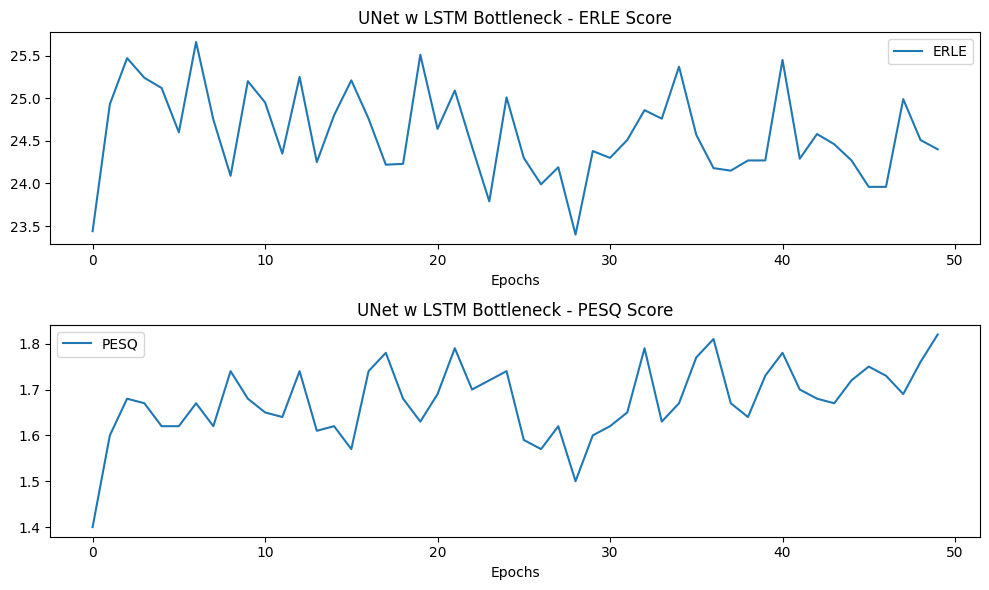

In [29]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet w LSTM Bottleneck - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet w LSTM Bottleneck - PESQ Score")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# torch.save(model, "./models/UNET_LSTM1.pth")
torch.save(model, "./models/UNET_LSTM1_L1Loss.pth")

In [ ]:
model = torch.load("./models/UNET_LSTM1.pth")
model = model.to('cuda') 
model.eval()


In [12]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase, near_wave) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = combined.unsqueeze(0)
combined_input.shape

torch.Size([1, 771, 512])

In [13]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="UNET_LSTM_1_L1Loss", n_fft=512, hop_length=256, sr=16000, write=1)
outputs.shape

(257, 512)

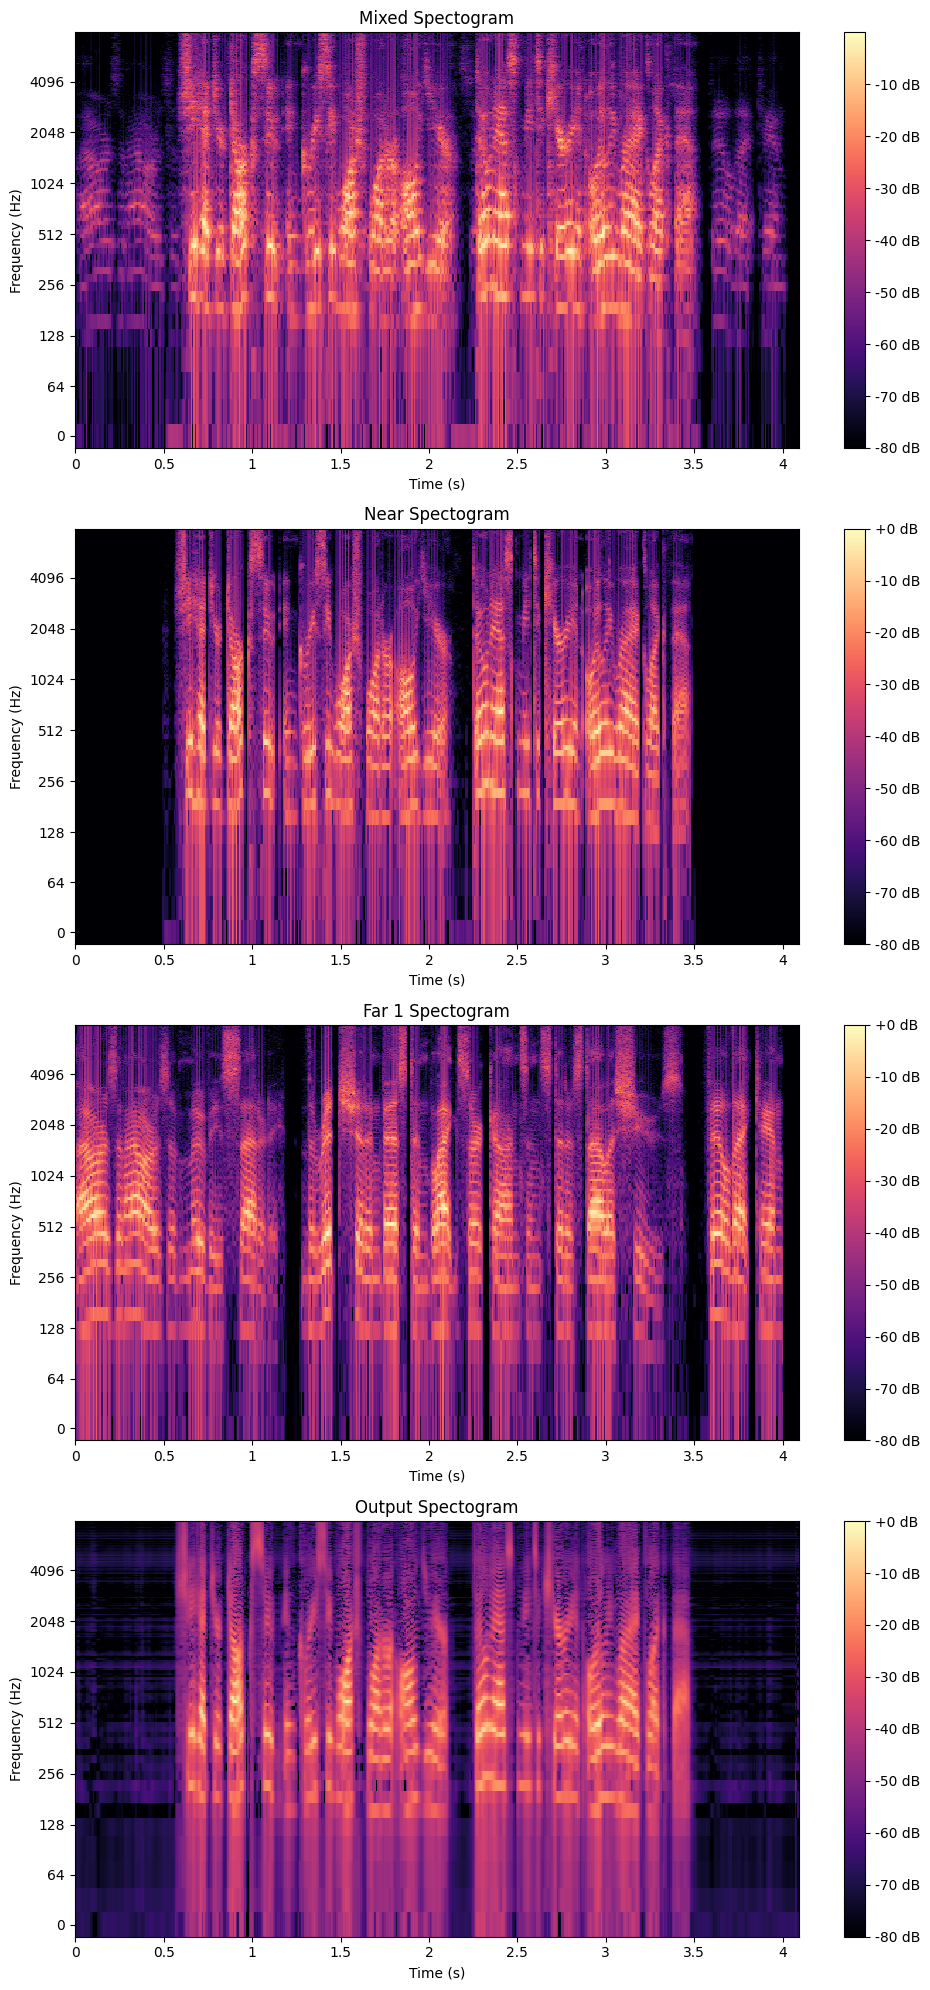

In [14]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

In [22]:
import torchaudio
import functions

near_wave, sr = torchaudio.load("./SampleFiles/near.wav")
output_wave, sr = torchaudio.load("./SampleFiles/UNET_LSTM_1_L1Loss.wav")

min_length = min(near_wave.shape[1], output_wave.shape[1])
near_wave = near_wave[:, :min_length]
output_wave = output_wave[:, :min_length]

output_wave = np.squeeze(output_wave.numpy())
near_wave = np.squeeze(near_wave.numpy())
print(f"ERLE Score: {functions.compute_erle(near_wave, output_wave):.2f}")
print(f"PESQ Score: {pesq(16000, near_wave, output_wave):.2f}")

ERLE Score: 25.89
PESQ Score: 1.65


##### UNET_LSTM_BN_3

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.LSTM = nn.LSTM(features[3], self.hidden_size, num_layers=2, batch_first=True)

        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        pool4_T = pool4.transpose(1, 2) # (batch, seq, features)
        bottleneck = self.LSTM(pool4_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck[0].transpose(1,2) # (batch, features, seq)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck_T)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [8]:
batch_size = 64
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet().to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 512, 512]             --
│    └─Conv1d: 2-1                       [1, 512, 512]             1,184,768
│    └─ReLU: 2-2                         [1, 512, 512]             --
│    └─Conv1d: 2-3                       [1, 512, 512]             786,944
│    └─BatchNorm1d: 2-4                  [1, 512, 512]             1,024
│    └─ReLU: 2-5                         [1, 512, 512]             --
├─MaxPool1d: 1-2                         [1, 512, 256]             --
├─Sequential: 1-3                        [1, 768, 256]             --
│    └─Conv1d: 2-6                       [1, 768, 256]             1,180,416
│    └─ReLU: 2-7                         [1, 768, 256]             --
│    └─Conv1d: 2-8                       [1, 768, 256]             1,770,240
│    └─BatchNorm1d: 2-9                  [1, 768, 256]  

In [9]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/40] Train Loss: 0.0091, Duration: 2 minutes 34 seconds, ERLE Score: 15.06, PESQ Score: 1.03
[Epoch   2/40] Train Loss: 0.0024, Duration: 1 minutes 40 seconds, ERLE Score: 30.43, PESQ Score: 1.05
[Epoch   3/40] Train Loss: 0.0015, Duration: 50 seconds, ERLE Score: 22.60, PESQ Score: 1.05
[Epoch   4/40] Train Loss: 0.0011, Duration: 53 seconds, ERLE Score: 24.43, PESQ Score: 1.09
[Epoch   5/40] Train Loss: 0.0013, Duration: 51 seconds, ERLE Score: 30.32, PESQ Score: 1.07
[Epoch   6/40] Train Loss: 0.0012, Duration: 54 seconds, ERLE Score: 30.28, PESQ Score: 1.08
[Epoch   7/40] Train Loss: 0.0011, Duration: 48 seconds, ERLE Score: 27.10, PESQ Score: 1.05
[Epoch   8/40] Train Loss: 0.0008, Duration: 51 seconds, ERLE Score: 26.14, PESQ Score: 1.07
[Epoch   9/40] Train Loss: 0.0009, Duration: 45 seconds, ERLE Score: 26.17, PESQ Score: 1.07
[Epoch  10/40] Train Loss: 0.0034, Duration: 45 seconds, ERLE Score: 32.32, PESQ Score: 1.14
[Epoch  11/40] Train Loss: 0.0009, Duration: 45 se

In [24]:
# the best training so far graph value
erle_arr = [15.06, 30.43, 22.6, 24.43, 30.32, 30.28, 27.1, 26.14, 26.17, 32.32, 23.93, 24.59, 26.42, 25.62, 26.61, 26.76, 22.97, 29.02, 24.25, 20.82, 25.88, 24.85, 23.56, 25.78, 27.15, 25.57, 24.35, 22.14, 25.16, 27.48, 26.77, 25.96, 25.25, 21.68, 22.55, 26.97, 25.07, 25.78, 22.86, 20.61]
pesq_arr = [
    1.08, 1.11, 1.15, 1.22, 1.28, 1.35, 1.38, 1.42,
    1.39, 1.49, 1.57, 1.45, 1.62, 1.64, 1.57, 1.66,
    1.60, 1.70, 1.74, 1.54, 1.68, 1.82, 1.72, 1.75,
    1.79, 1.6, 1.80, 1.71, 1.76, 1.82, 1.69, 1.74,
    1.76, 1.82, 1.81, 1.85, 1.78, 1.84, 1.78, 1.84
]

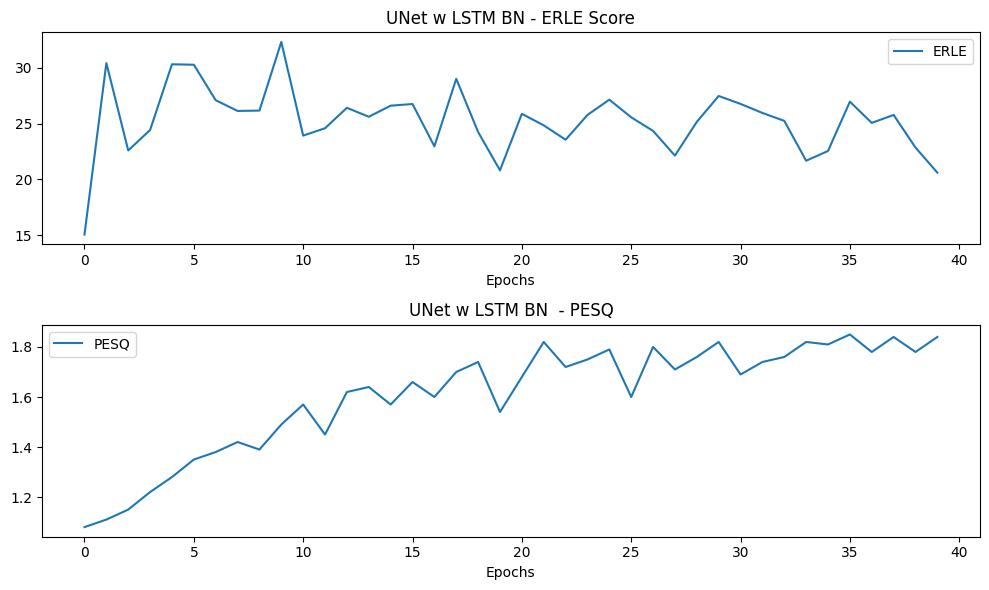

In [25]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet w LSTM BN - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet w LSTM BN  - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
torch.save(model, "./models/UNET_LSTM3.pth")

In [23]:
model = torch.load("./models/UNET_LSTM3.pth")
model = model.to('cuda') 
model.eval()


UNet(
  (encoder_conv1): Sequential(
    (0): Conv1d(771, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
  )
  (encoder_pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Sequential(
    (0): Conv1d(512, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
  )
  (encoder_pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Sequential(
    (0): Conv1d(768, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(1024, 1024, k

In [24]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = combined.unsqueeze(0)
combined_input.shape

torch.Size([1, 771, 512])

In [25]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="UNET_LSTM_3", n_fft=512, hop_length=256, sr=16000, write=1)


array([2.7128437e-04, 1.2972513e-04, 4.4910485e-05, ..., 7.3026895e-05,
       4.1415679e-04, 1.8178420e-04], dtype=float32)

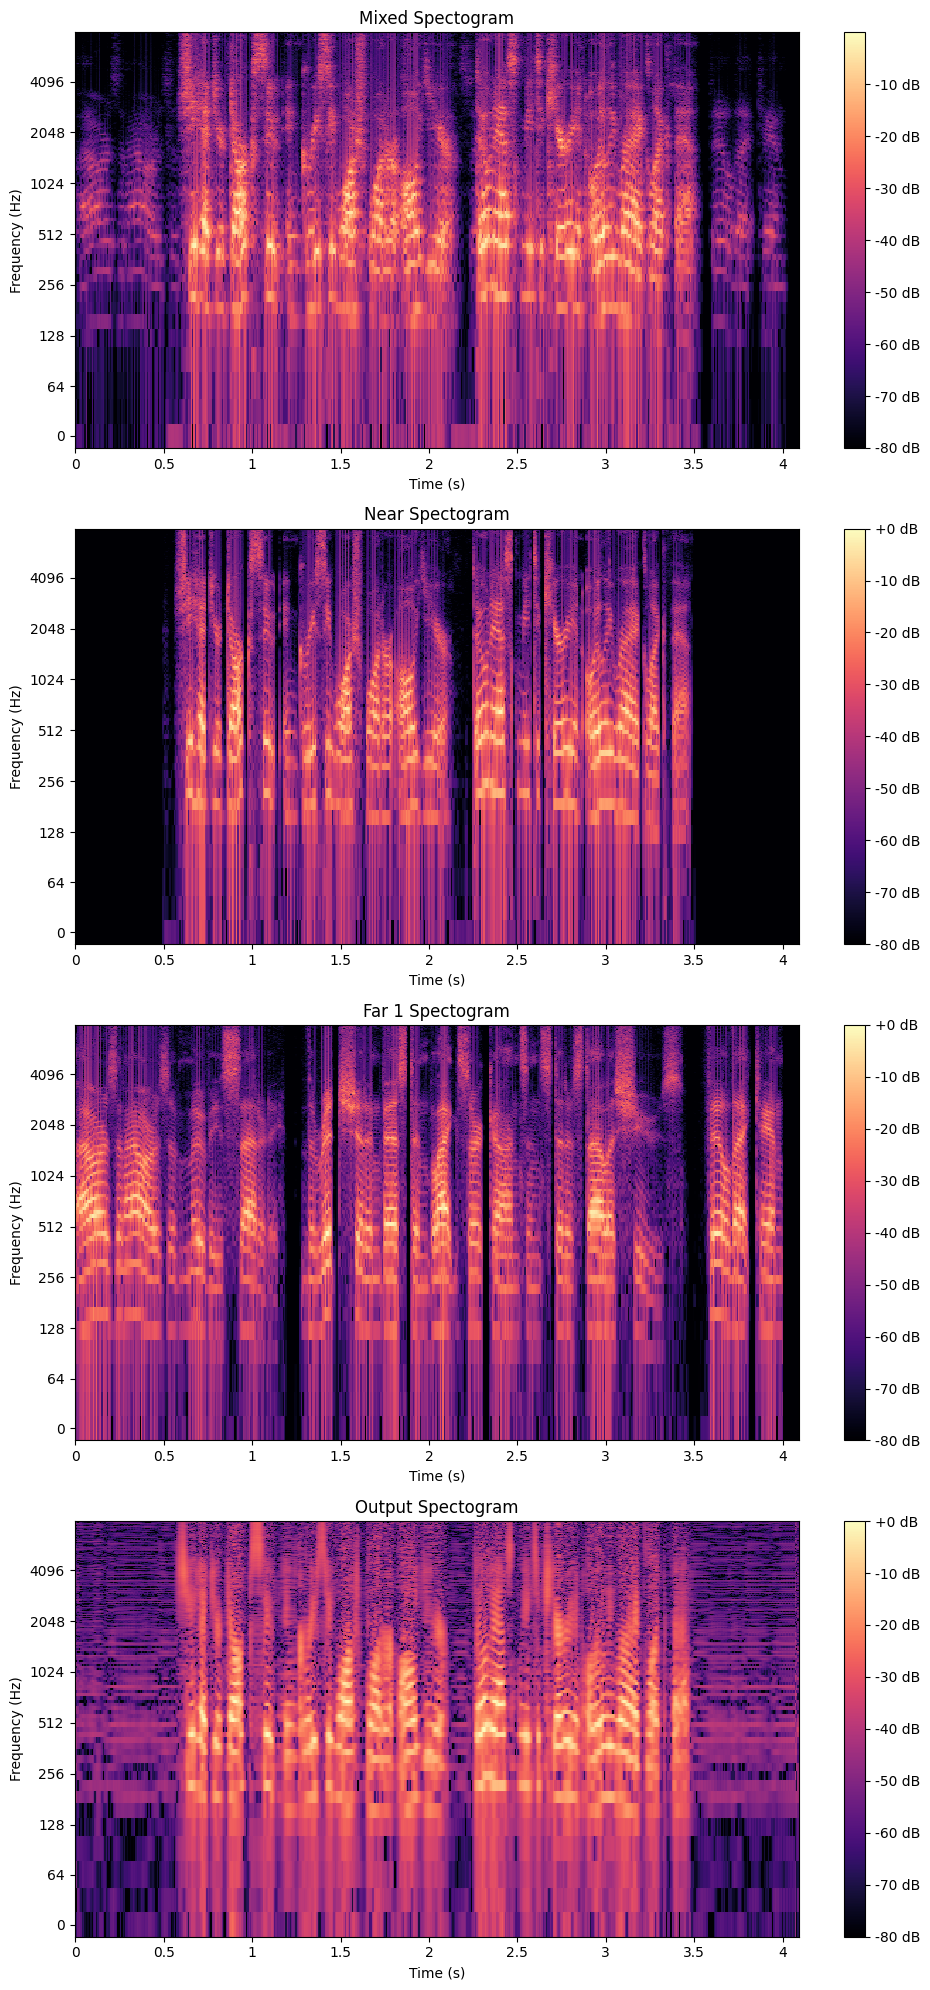

In [26]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### UNET_LSTM_Attention 2

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, input_size, embed_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.W_q = nn.Linear(input_size, embed_size)
        self.W_k = nn.Linear(input_size, embed_size)
        self.W_v = nn.Linear(input_size, embed_size)
        self.fc_out = nn.Linear(embed_size, input_size)
    
    def forward(self, x):
        # Apply linear transformations to obtain query, key, and value vectors
        query = self.W_q(x)
        key = self.W_k(x)
        value = self.W_v(x)
        
        # Calculate scaled dot-product attention scores
        attention_scores = torch.matmul(query, key.transpose(1, 2)) / torch.sqrt(torch.tensor(self.embed_size).float())
        
        # Apply softmax to obtain attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Apply attention weights to the values
        attended_values = torch.matmul(attention_weights, value)
        
        # Linear transformation to obtain the final output
        out = self.fc_out(attended_values)
        return out

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [200, 250, 300, 350], max_frames=512):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.LSTM = nn.LSTM(features[3], self.hidden_size, num_layers=2, batch_first=True)

        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution
        self.out_attention = SelfAttention(max_frames, out_channels) # convert last axis(max_frames) to out_channels size and then back to last axis

    

    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        pool4_T = pool4.transpose(1, 2) # (batch, seq, features)
        bottleneck = self.LSTM(pool4_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck[0].transpose(1,2) # (batch, features, seq)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck_T)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        attention_output = self.out_attention(output)
        return attention_output

In [7]:
batch_size = 32
num_epochs = 60
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = UNet().to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 200, 512]             --
│    └─Conv1d: 2-1                       [1, 200, 512]             462,800
│    └─ReLU: 2-2                         [1, 200, 512]             --
│    └─Dropout: 2-3                      [1, 200, 512]             --
│    └─Conv1d: 2-4                       [1, 200, 512]             120,200
│    └─ReLU: 2-5                         [1, 200, 512]             --
├─MaxPool1d: 1-2                         [1, 200, 256]             --
├─Sequential: 1-3                        [1, 250, 256]             --
│    └─Conv1d: 2-6                       [1, 250, 256]             150,250
│    └─ReLU: 2-7                         [1, 250, 256]             --
│    └─Dropout: 2-8                      [1, 250, 256]             --
│    └─Conv1d: 2-9                       [1, 250, 256]             187

In [9]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/60] Train Loss: 0.0014, Duration: 1 minutes 21 seconds, ERLE Score: 34.46, PESQ Score: 1.04
[Epoch   2/60] Train Loss: 0.0027, Duration: 23 seconds, ERLE Score: 37.43, PESQ Score: 1.05
[Epoch   3/60] Train Loss: 0.0018, Duration: 23 seconds, ERLE Score: 34.74, PESQ Score: 1.04
[Epoch   4/60] Train Loss: 0.0016, Duration: 23 seconds, ERLE Score: 33.27, PESQ Score: 1.05
[Epoch   5/60] Train Loss: 0.0015, Duration: 23 seconds, ERLE Score: 31.76, PESQ Score: 1.06
[Epoch   6/60] Train Loss: 0.0006, Duration: 23 seconds, ERLE Score: 30.26, PESQ Score: 1.09
[Epoch   7/60] Train Loss: 0.0028, Duration: 23 seconds, ERLE Score: 32.55, PESQ Score: 1.06
[Epoch   8/60] Train Loss: 0.0013, Duration: 22 seconds, ERLE Score: 31.72, PESQ Score: 1.09
[Epoch   9/60] Train Loss: 0.0017, Duration: 22 seconds, ERLE Score: 31.65, PESQ Score: 1.08
[Epoch  10/60] Train Loss: 0.0005, Duration: 22 seconds, ERLE Score: 30.51, PESQ Score: 1.08
[Epoch  11/60] Train Loss: 0.0014, Duration: 22 seconds, ERL

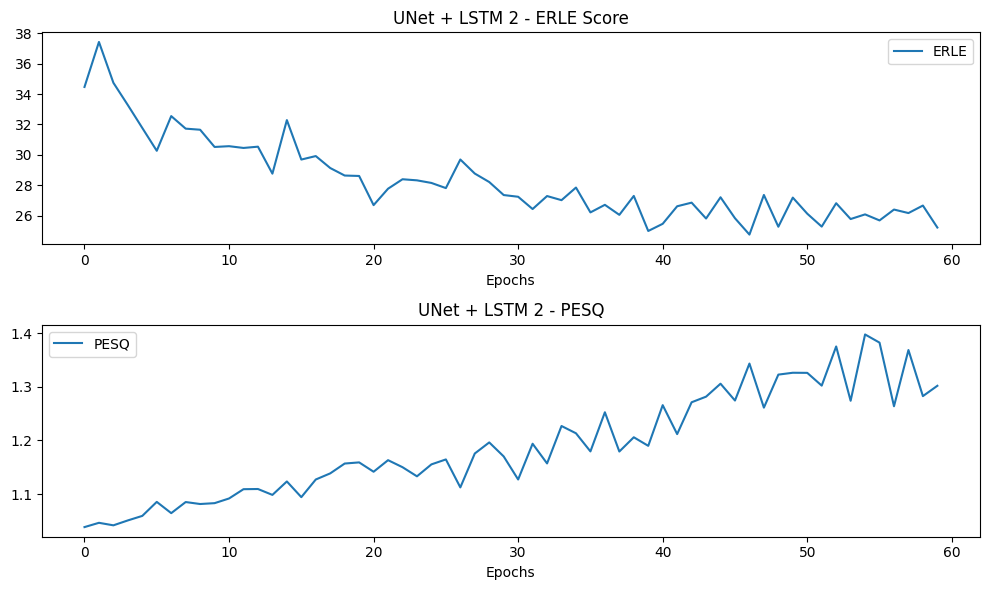

In [10]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 2 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 2 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model, "./models/UNET_LSTM2.pth")

In [11]:
model = torch.load("./models/UNET_LSTM2.pth")
model = model.to('cuda') 
model.eval()


UNet(
  (encoder_conv1): Sequential(
    (0): Conv1d(771, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Sequential(
    (0): Conv1d(512, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv3): Sequential(
    (0): Conv1d(768, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder

In [11]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase, near_wave) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = combined.unsqueeze(0)
combined_input.shape

torch.Size([1, 771, 512])

In [18]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase.numpy(), filename="UNET_LSTM_2", n_fft=512, hop_length=256, sr=16000, write=1)


array([3.6547040e-06, 2.7359795e-06, 2.1768358e-06, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

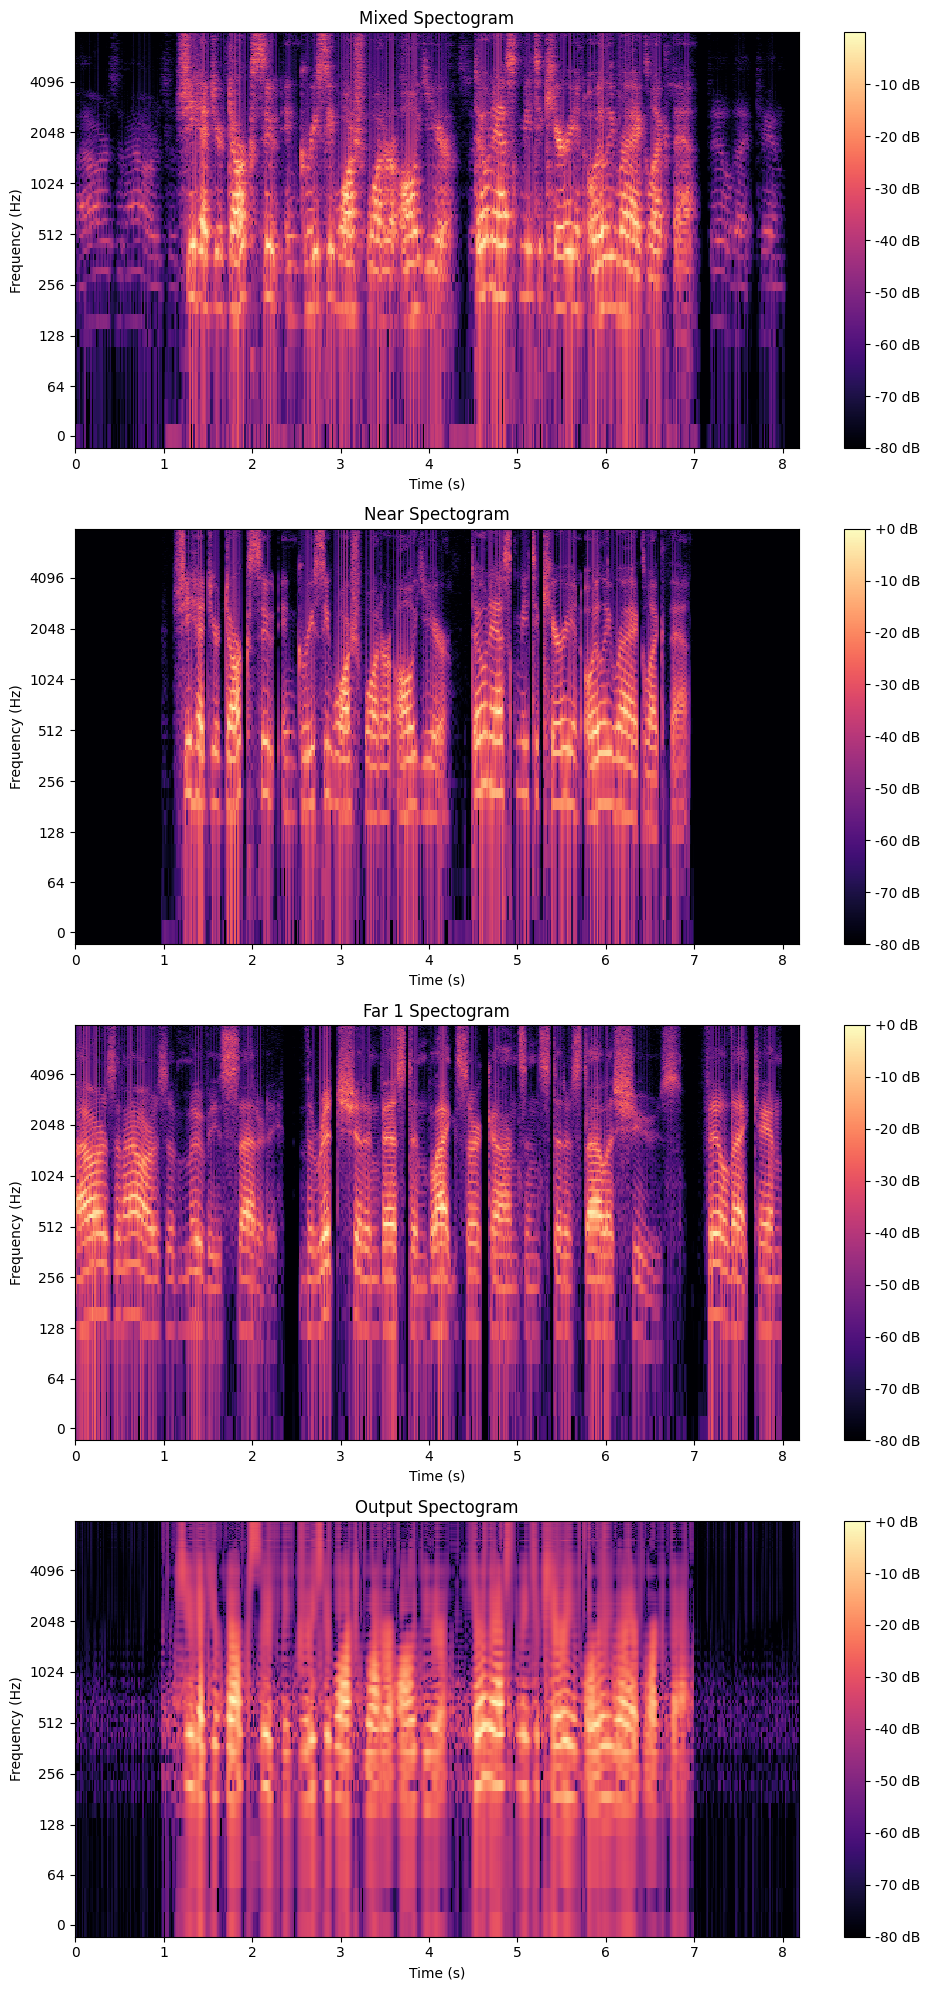

In [19]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### UNET_Conformer 2

In [14]:
class ConformerBlock(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.ffn1 = FeedForward(dim, int(dim * mlp_ratio), dropout)
        self.depthwise_conv = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=dim)
        self.pointwise_conv = nn.Conv1d(dim, dim, kernel_size=1)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn2 = FeedForward(dim, int(dim * mlp_ratio), dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.ffn1(self.norm1(x.transpose(1, 2)).transpose(1, 2)))
        x = x + self.dropout(self.pointwise_conv(self.depthwise_conv(x)))
        x = x + self.dropout(self.ffn2(self.norm2(x.transpose(1, 2)).transpose(1, 2)))
        return x
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x.transpose(1, 2)).transpose(1, 2)

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [200, 250, 300, 350], num_conformer_blocks=2):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck Conformer
        self.conformer_blocks = nn.Sequential(*[ConformerBlock(features[3]) for _ in range(num_conformer_blocks)])
        self.bottleneck_linear = nn.Linear(features[3], features[3]*2)
        
        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution

    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # Bottleneck (Conformer)
        bottleneck = self.conformer_blocks(pool4)
        bottleneck = self.bottleneck_linear(bottleneck.transpose(1,2)).transpose(1,2)
        
        # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [16]:
batch_size = 32
num_epochs = 60
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
model = UNet().to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 200, 512]             --
│    └─Conv1d: 2-1                       [1, 200, 512]             462,800
│    └─ReLU: 2-2                         [1, 200, 512]             --
│    └─Dropout: 2-3                      [1, 200, 512]             --
│    └─Conv1d: 2-4                       [1, 200, 512]             120,200
│    └─ReLU: 2-5                         [1, 200, 512]             --
├─MaxPool1d: 1-2                         [1, 200, 256]             --
├─Sequential: 1-3                        [1, 250, 256]             --
│    └─Conv1d: 2-6                       [1, 250, 256]             150,250
│    └─ReLU: 2-7                         [1, 250, 256]             --
│    └─Dropout: 2-8                      [1, 250, 256]             --
│    └─Conv1d: 2-9                       [1, 250, 256]             187

In [18]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/60] Train Loss: 0.0013, Duration: 1 minutes 12 seconds, ERLE Score: 31.87, PESQ Score: 1.07
[Epoch   2/60] Train Loss: 0.0007, Duration: 23 seconds, ERLE Score: 28.32, PESQ Score: 1.09
[Epoch   3/60] Train Loss: 0.0003, Duration: 22 seconds, ERLE Score: 28.03, PESQ Score: 1.12
[Epoch   4/60] Train Loss: 0.0004, Duration: 22 seconds, ERLE Score: 27.99, PESQ Score: 1.14
[Epoch   5/60] Train Loss: 0.0005, Duration: 22 seconds, ERLE Score: 24.90, PESQ Score: 1.20
[Epoch   6/60] Train Loss: 0.0023, Duration: 22 seconds, ERLE Score: 30.15, PESQ Score: 1.32
[Epoch   7/60] Train Loss: 0.0013, Duration: 22 seconds, ERLE Score: 25.58, PESQ Score: 1.33
[Epoch   8/60] Train Loss: 0.0004, Duration: 22 seconds, ERLE Score: 25.70, PESQ Score: 1.34
[Epoch   9/60] Train Loss: 0.0011, Duration: 22 seconds, ERLE Score: 25.53, PESQ Score: 1.32
[Epoch  10/60] Train Loss: 0.0010, Duration: 22 seconds, ERLE Score: 25.67, PESQ Score: 1.38
[Epoch  11/60] Train Loss: 0.0008, Duration: 22 seconds, ERL

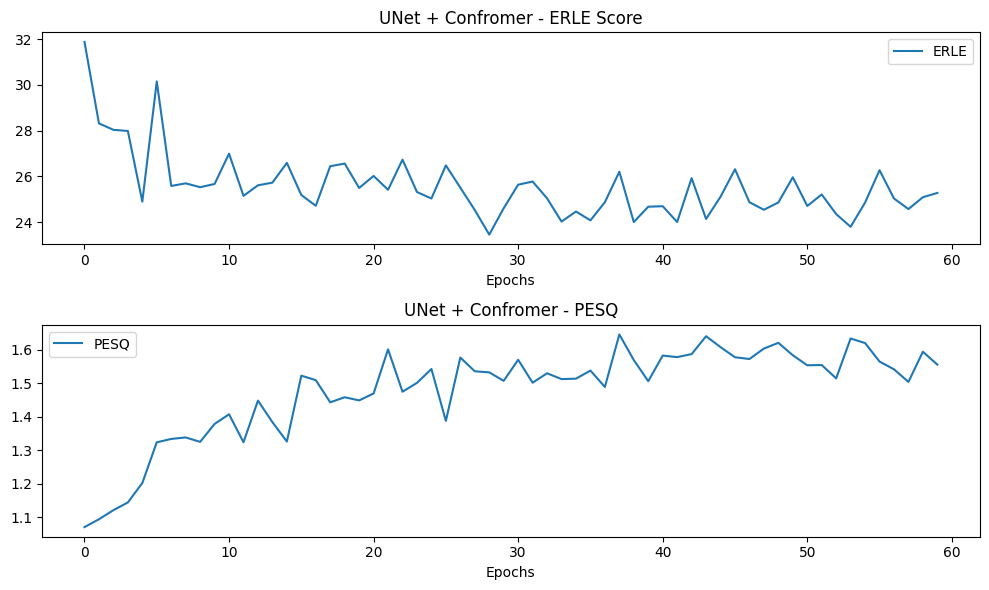

In [19]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + Confromer - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + Confromer - PESQ Score")
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
torch.save(model, "./models/UNET_conformer.pth")

In [ ]:
model = torch.load("./models/UNET_conformer.pth")
model = model.to('cuda') 
model.eval()


In [21]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase, near_wave) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = combined.unsqueeze(0)
combined_input.shape

torch.Size([1, 771, 512])

In [22]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase.numpy(), filename="UNET_Confromer", n_fft=512, hop_length=256, sr=16000, write=1)


array([-1.9904643e-05, -1.4704952e-05, -1.3776520e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

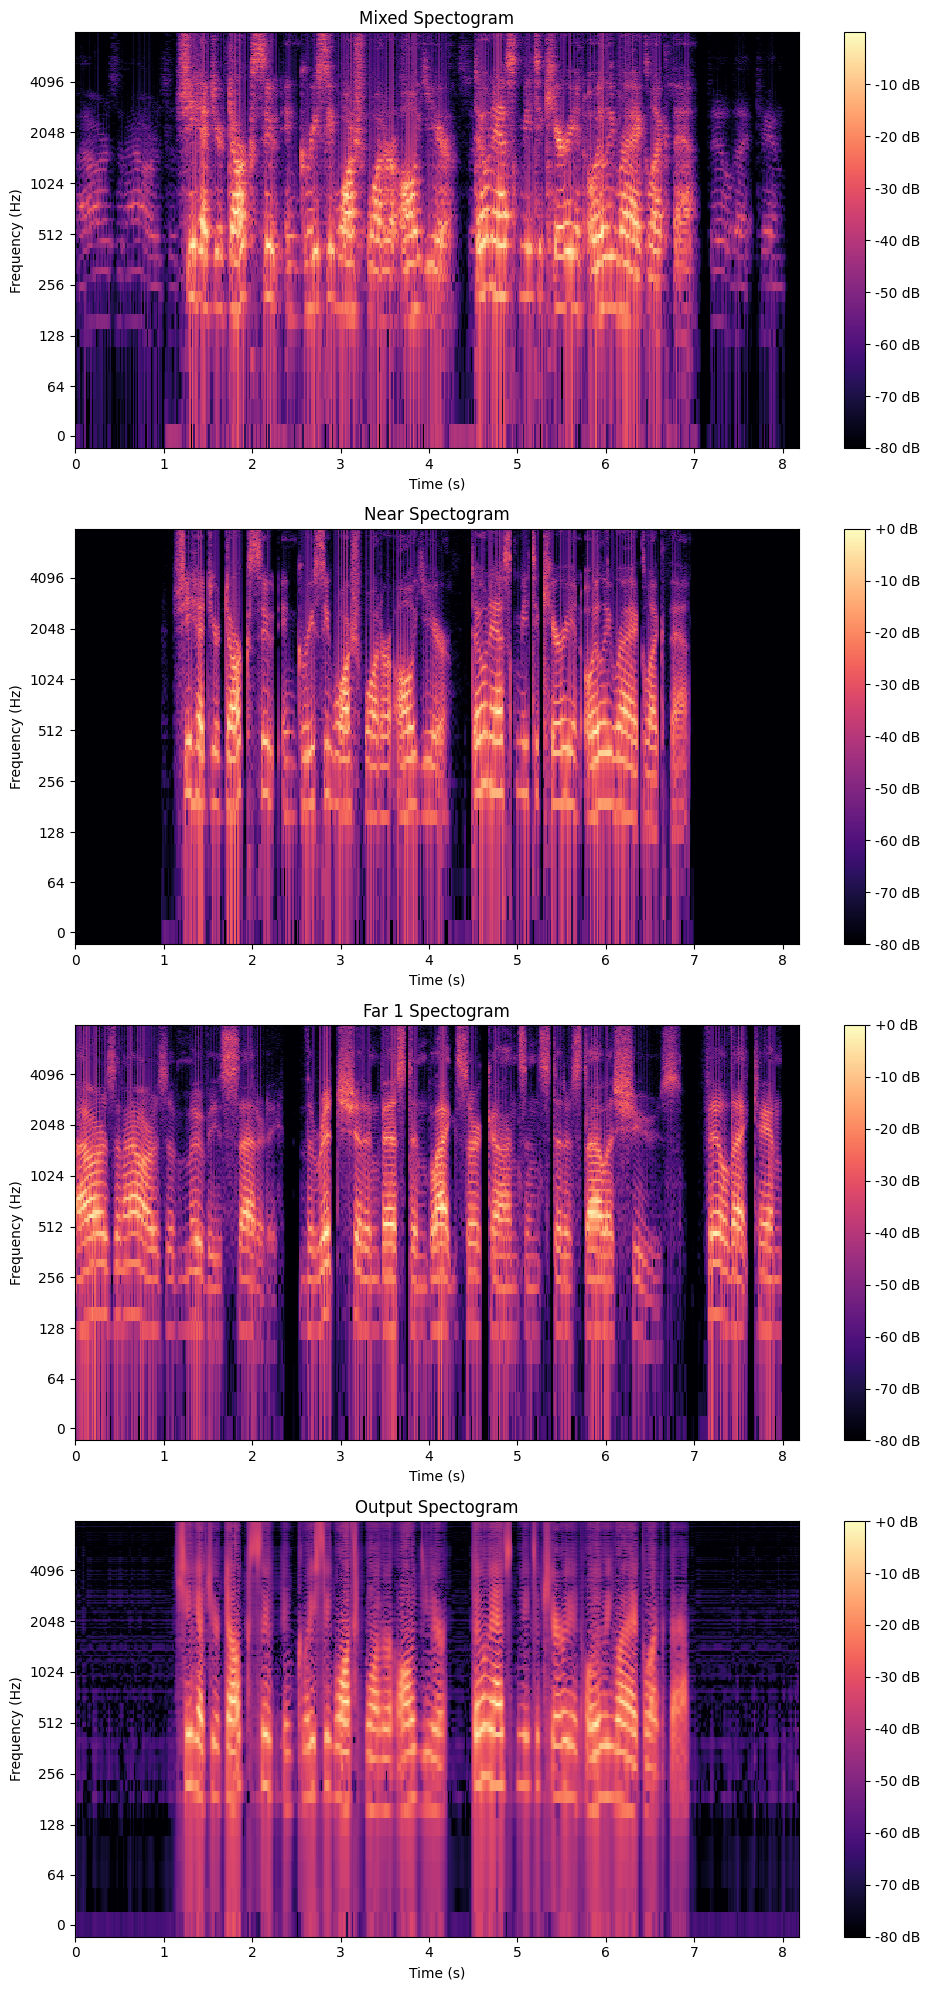

In [23]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)